# Loading NWB files and extracting e-features

Author: Darshan Mandge, Open Brain Institute

Copyright (c) 2025 Open Brain Institute

This notebook demonstrates how to load electrophysiology data using Neo for eFEL eFeatures extraction.

In [1]:
import efel
import numpy as np
import h5py

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10, 10

We will use the voltage trace recordings obtained from a mouse thalamic cell classified as a bursting accommodating (bAC) etype. The data is stored in an NWB (Neurodata Without Borders) file, and we will use the [Python Neo](https://github.com/NeuralEnsemble/python-neo) library to load it.

In [2]:
test_data = "C291001A2-MT-C1.nwb" # data file should be replaced with file downloaded from the link or a direct link to the file

# Read the data
data = h5py.File(test_data, 'r')

# Find the keys in the nwb data
data.keys()

<KeysViewHDF5 ['acquisition', 'analysis', 'data_organization', 'file_create_date', 'general', 'identifier', 'processing', 'session_description', 'session_start_time', 'specifications', 'stimulus', 'timestamps_reference_time']>

In [3]:
# find the entries in the acquisition group
data["acquisition"].keys()

<KeysViewHDF5 ['ccs__ADHPdepol__139', 'ccs__ADHPhyperpol__140', 'ccs__ADHPhyperpol__179', 'ccs__ADHPhyperpol__180', 'ccs__ADHPhyperpol__181', 'ccs__ADHPhyperpol__182', 'ccs__ADHPrest__141', 'ccs__APDrop__142', 'ccs__APThreshold__010', 'ccs__APThreshold__011', 'ccs__APThreshold__012', 'ccs__APWaveform__058', 'ccs__APWaveform__059', 'ccs__APWaveform__060', 'ccs__APWaveform__061', 'ccs__APWaveform__062', 'ccs__APWaveform__063', 'ccs__APWaveform__064', 'ccs__APWaveform__065', 'ccs__APWaveform__066', 'ccs__APWaveform__067', 'ccs__APWaveform__068', 'ccs__APWaveform__069', 'ccs__APWaveform__070', 'ccs__APWaveform__071', 'ccs__APWaveform__072', 'ccs__APWaveform__073', 'ccs__APWaveform__074', 'ccs__APWaveform__075', 'ccs__C1_HP_1sec__190', 'ccs__C1_HP_1sec__191', 'ccs__C1_HP_1sec__192', 'ccs__C1_HP_1sec__193', 'ccs__C1_HP_1sec__194', 'ccs__C1_HP_1sec__195', 'ccs__C1_HP_1sec__196', 'ccs__C1_HP_1sec__197', 'ccs__C1_HP_1sec__198', 'ccs__C1_HP_1sec__199', 'ccs__C1_HP_1sec__200', 'ccs__C1_HP_1sec__2

Select the trace from acquisition that you want to plot, covert the data to numpy arrays and plot them

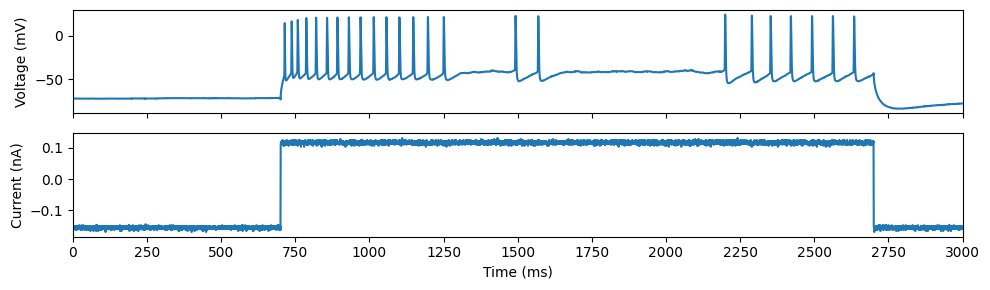

In [4]:

trace_name = "ccs__IDRest__131"
voltage = data["acquisition"][trace_name]["data"]
current_trace_name = trace_name.replace("ccs_", "ccss_")
current = data["stimulus"]["presentation"][current_trace_name]["data"]

v_array = np.array(
            voltage * voltage.attrs["conversion"], dtype="float32"
        ) * 1e3 # convert to mV
i_array = np.array(
    current[()] * current.attrs["conversion"], dtype="float32"
) * 1e9 # convert to nA

start_time = data["stimulus"]["presentation"][current_trace_name]["starting_time"]
dt = 1. / float(start_time.attrs["rate"])

t_array = np.arange(0, len(v_array)) * dt * 1000 # multiply by 1000 to convert to ms

# create a subplot with shared x axis to plot the voltage and current traces
fig, axs = plt.subplots(nrows = 2, ncols=1, figsize=(10,3) ,sharex=True)
axs[0].plot(t_array, v_array)
axs[0].set_ylabel("Voltage (mV)")
axs[1].plot(t_array, i_array)
axs[1].set_ylabel("Current (nA)")
axs[1].set_xlabel("Time (ms)")
axs[1].set_xlim(0, t_array[-1])
axs[1].set_xticks(np.arange(0, t_array[-1] + 1, 250)) # set xticks at every 250 ms
plt.tight_layout()
plt.show()

The current clamp starts around 700 ms and ends near 2700 ms. We will use these values to extract features from the voltage trace using eFEL.

Let's create a `trace` dictionary to extract features from voltage trace show above.

In [5]:
stim_start = 700
stim_end = 2700
trace = {"T": t_array, "V": v_array, "stim_start": [0], "stim_end": [t_array[-1]]}

We can now use the eFEL to extract eFeature values from the trace shown above.

We will use the ``get_feature_values()`` function, which accepts a list of trace and the requested eFeature names as input.

Let's extract some burst-related features

In [6]:
efel.set_setting("ignore_first_ISI", False) # Don't ignore the first spike
efel.set_setting("strict_burst_factor", 4.0) # The burst detection can be fine-tuned by changing the setting strict_burst_factor. Default value is 2.0.
feature_values = efel.get_feature_values([trace], ['spikes_per_burst', 'strict_burst_number', 'strict_burst_mean_freq', 'peak_time', 'AP_height', 'peak_indices', 'burst_begin_indices', 'burst_end_indices'])[0]
feature_values

{'spikes_per_burst': array([15,  7]),
 'strict_burst_number': array([2]),
 'strict_burst_mean_freq': array([27.94857462, 16.09935603]),
 'peak_time': array([ 714.3,  737.8,  758.3,  787.2,  820.3,  857. ,  892. ,  930.5,
         970. , 1014.5, 1057.5, 1101. , 1147.8, 1197.3, 1251. , 1492.8,
        1569.5, 2199.7, 2289.7, 2353. , 2421.3, 2492.7, 2563. , 2634.5]),
 'AP_height': array([14.06181393, 16.24295807, 18.0741188 , 20.1177681 , 20.43025513,
        20.53025055, 20.93647766, 21.09272003, 21.12397003, 21.3114624 ,
        21.21771431, 21.06147194, 21.21146698, 21.31145973, 21.43645477,
        22.69264374, 22.405159  , 23.87383728, 23.08012352, 22.56140136,
        22.29266167, 22.35515899, 22.56140136, 22.09267424]),
 'peak_indices': array([ 7143,  7378,  7583,  7872,  8203,  8570,  8920,  9305,  9700,
        10145, 10575, 11010, 11478, 11973, 12510, 14928, 15695, 21997,
        22897, 23530, 24213, 24927, 25630, 26345]),
 'burst_begin_indices': array([ 0, 17]),
 'burst_end_ind

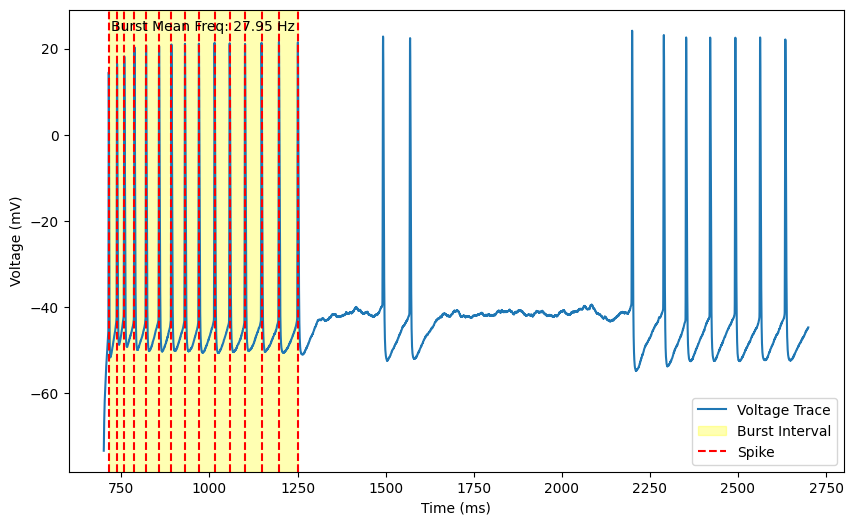

In [7]:
burst_begin_indices = feature_values['burst_begin_indices'][0]
burst_end_indices = feature_values['burst_end_indices'][0]
peak_times = feature_values['peak_time']
ap_heights = feature_values['AP_height']
burst_mean_freq = feature_values['strict_burst_mean_freq']

time_spike_indices = np.where((t_array > stim_start) & (t_array < stim_end))
time_spike = t_array[time_spike_indices]
voltage_spike = v_array[time_spike_indices]

plt.figure(figsize=(10, 6))
plt.plot(time_spike, voltage_spike, label='Voltage Trace')

burst_start = peak_times[burst_begin_indices]
burst_end = peak_times[burst_end_indices]
mean_frequency = burst_mean_freq[0]

plt.axvspan(burst_start, burst_end, color='yellow', alpha=0.3, label='Burst Interval')

for spike_time in peak_times[burst_begin_indices:burst_end_indices+1]:
    plt.axvline(x=spike_time, color='red', linestyle='--', label='Spike' if 'Spike' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.text((burst_start + burst_end) / 2, max(voltage_spike), f'Burst Mean Freq: {mean_frequency:.2f} Hz', horizontalalignment='center', color='black')

plt.legend()
# show only till 1400 ms
# plt.xlim(0, 1400)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.show()

We can save the feature values obtained from `get_feature_values` for later use. Two functions, `save_feature_values_to_json` and `save_feature_values_to_csv`, are provided for this purpose. They save the feature values as a JSON file and a CSV file, respectively.

In [8]:
# efel.io.save_feature_to_json(feature_values, 'output.json')
# efel.io.save_feature_to_csv(feature_values, 'output.csv')